In [ ]:
!nvidia-smi

Mon Sep  6 15:47:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Project Pipeline**

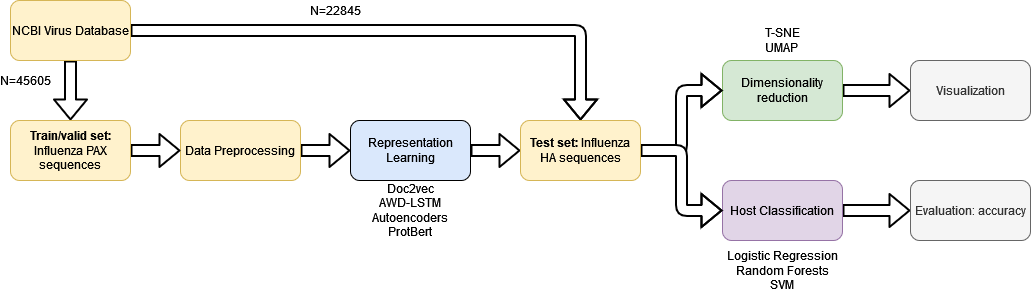

In this notebook, we use AWD-LSTM to extract viral protein embeddings, that we later visualize them by applying dimensionalilty reduction, or use them to determine the predicted host for the influenza A virus

In [ ]:
!pip install fastai -q --upgrade > /dev/null
# !pip install sentencepiece!=0.1.90,!=0.1.91 > /dev/null
!pip install Bio > /dev/null
!pip install umap-learn > /dev/null
!pip install wandb
# !pip install tensorboard

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 170 kB 48.4 MB/s 
     |████████████████████████████████| 133 kB 43.7 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=3b6096ccd0f5c451f99f754dcc45a62a6f013f700f2634e17d9ebc14b5d44b8e
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=adc0851e9a656f40e784d762fb8f98ac402999eec14572c924f40af68e642192
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


We relied on the fastai library since this model is already implemented in it and can be used easily, and more then that we can benefit from state
of the art training techniques that fastai uses by default, like the one cycle policy that was proposed by Leslie Smith in 2018, and it is claimed to speed
up training and makes it smoother. This is done by increasing the learning rate linearly up to a maximum point that we specify, and then decreasing it slowly again.
Starting with a lower learning serves as a warmup for the network, until we reach bigger values that can help with escaping saddle points, then we start decreasing the learning rate to travel smoothly towards the minimum.

In [ ]:
from fastai.text.all import *
from fastai.callback.tensorboard import *
import pandas as pd
import numpy as np
import torch as torch
from Bio import SeqIO
import time
import umap
from sklearn.manifold import TSNE
import seaborn as sns


import wandb
from fastai.callback.wandb import WandbCallback

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = Path('/content/drive/MyDrive/PFE')
dls_path = path/'dls'
model_path = path/'models'
spm_path = model_path/'spms'

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project='awdlstm2')

wandb: Currently logged in as: oumaimaelmiayar (use `wandb login --relogin` to force relogin)


We ilustrate the inference process of AWD-LSTM as following :

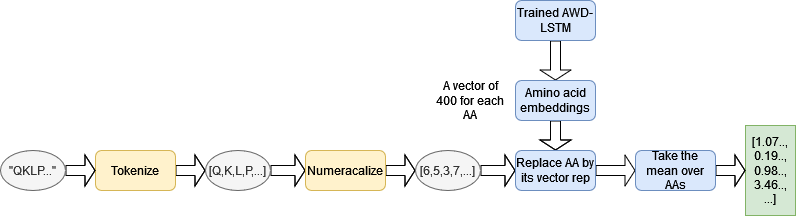

# **Data Preprocessing**

# FASTA to CSV

We try to convert the FASTA file to CSV using Bio.SeqIO ;
The resulting csv file will be combined with the annotation table to obtain finally the table which contains the amino acid sequences with the corresponding information.

In [ ]:
records = SeqIO.parse(path/'data/FASTA_PAX.fa', 'fasta')

In [ ]:
ids = []
seqs = []
for record in records:
  ids.append(record.id)
  seqs.append(record.seq)

In [ ]:
df = pd.DataFrame(list(zip(ids, seqs)), columns=['ids', 'sequences'])

In [ ]:
df.head()

,ids,sequences
0,AXF38683,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)"
1,AXF38697,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)"
2,AXF38671,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)"
3,AHM98512,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, I, M, A, W, T, V, V, N, S, I, C, N, T, T, G, L, ...)"
4,AHM98523,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, I, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)"


In [ ]:
df_meta = pd.read_csv(path/'data/flu_pax.txt')
df_meta.head()

,accession,length,host,protein,serotype,country,region,date,name,mutations,age,gender,lineage,vac_strain,fulllength_plus
0,AXF38683,252,Avian,PA-X,H10N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
1,AXF38697,252,Avian,PA-X,H12N5,Australia,S,2013,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
2,AXF38671,252,Avian,PA-X,H6N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
3,AHM98512,232,Human,PA-X,H1N1,Denmark,N,2011/01/25,Influenza A virus (A/Aarhus/INS3_653/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c
4,AHM98523,232,Human,PA-X,H1N1,Denmark,N,2011/01/14,Influenza A virus (A/Aarhus/INS3_654/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c


In [ ]:
df = df.merge(df_meta, left_on='ids', right_on='accession')

In [ ]:
df.drop(columns='accession', inplace=True)

In [ ]:
df.head()

,ids,sequences,length,host,protein,serotype,country,region,date,name,mutations,age,gender,lineage,vac_strain,fulllength_plus
0,AXF38683,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)",252,Avian,PA-X,H10N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
1,AXF38697,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)",252,Avian,PA-X,H12N5,Australia,S,2013,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
2,AXF38671,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, T, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)",252,Avian,PA-X,H6N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
3,AHM98512,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, I, M, A, W, T, V, V, N, S, I, C, N, T, T, G, L, ...)",232,Human,PA-X,H1N1,Denmark,N,2011/01/25,Influenza A virus (A/Aarhus/INS3_653/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c
4,AHM98523,"(M, E, D, F, V, R, Q, C, F, N, P, M, I, V, E, L, A, E, K, A, M, K, E, Y, G, E, D, P, K, I, E, T, N, K, F, A, A, I, C, T, H, L, E, V, C, F, M, Y, S, D, F, H, F, I, D, E, R, G, E, S, I, I, V, E, S, G, D, P, N, A, L, L, K, H, R, F, E, I, I, E, G, R, D, R, I, M, A, W, T, V, V, N, S, I, C, N, T, T, G, V, ...)",232,Human,PA-X,H1N1,Denmark,N,2011/01/14,Influenza A virus (A/Aarhus/INS3_654/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c


In [ ]:
len(df)

45605

In [ ]:
def tup_to_string(tup):
  return ''.join(tup)

In [ ]:
df['sequences'] = df['sequences'].apply(lambda x: ''.join(x))

In [ ]:
df.head()

,ids,sequences,length,host,protein,serotype,country,region,date,name,mutations,age,gender,lineage,vac_strain,fulllength_plus
0,AXF38683,MEDFVRQCFNPMIVELAEKAMKEYGEDPKIETNKFAAICTHLEVCFMYSDFHFIDERGESIIVESGDPNALLKHRFEIIEGRDRTMAWTVVNSICNTTGVDKPKFLPDLYDYKENRFIEIGVTRREVHIYYLEKANKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRGLWDSFVNPREAKRQLKKDLKSQEPCAGLPTKVSHRTSPALKTLEPMWMDSNRTAALRASFLKCQKK,252,Avian,PA-X,H10N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
1,AXF38697,MEDFVRQCFNPMIVELAEKAMKEYGEDPKIETNKFAAICTHLEVCFMYSDFHFIDERGESIIVESGDPNALLKHRFEIIEGRDRTMAWTVVNSICNTTGVDKPKFLPDLYDYKKNRFIEIGVTRREVHIYYLEKANKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRGLWDSFVSPREAKRQLKKDLKSQEPCAGLPTKVSHRTSPALKTLEPMWMDSNRTAALRASFLKCQKK,252,Avian,PA-X,H12N5,Australia,S,2013,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
2,AXF38671,MEDFVRQCFNPMIVELAEKAMKEYGEDPKIETNKFAAICTHLEVCFMYSDFHFIDERGESIIVESGDPNALLKHRFEIIEGRDRTMAWTVVNSICNTTGVDKPKFLPDLYDYKENRFIEIGVTRREVHIYYLEKANKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRGLWDSFVNPREAKRQLKKDLKSQEPCAGLPTKVSHRTSPALKTLEPMWMDSNRTAALRASFLKCQKK,252,Avian,PA-X,H6N8,Australia,S,2014,Influenza A virus,NaN,NaN,NaN,NaN,NaN,c
3,AHM98512,MEDFVRQCFNPMIVELAEKAMKEYGEDPKIETNKFAAICTHLEVCFMYSDFHFIDERGESIIVESGDPNALLKHRFEIIEGRDRIMAWTVVNSICNTTGLEKPKFLPDLYDYKENRFIEIGVTRREVHIYYLEKANKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRSLWDSFVSPKEAKRQLKKNLRLQELCASLPTKVSHQTSPALKTSEPM,232,Human,PA-X,H1N1,Denmark,N,2011/01/25,Influenza A virus (A/Aarhus/INS3_653/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c
4,AHM98523,MEDFVRQCFNPMIVELAEKAMKEYGEDPKIETNKFAAICTHLEVCFMYSDFHFIDERGESIIVESGDPNALLKHRFEIIEGRDRIMAWTVVNSICNTTGVEKPKFLPDLYDYKENRFIEIGVTRREVHIYYLEKASKIKSEKTHIHIFSFTGEEMATKADYTLDEESRARIKTRLFTIRQEMASRSLWDSFVSPKEAKRQLKKNLRLQELCASLPTKVSHQTSPALKTLEPI,232,Human,PA-X,H1N1,Denmark,N,2011/01/14,Influenza A virus (A/Aarhus/INS3_654/2011(H1N1)),NaN,NaN,NaN,NaN,NaN,c


In [ ]:
df.to_csv(path/'data/prot_sequences_pax_3.csv')

# **Language Model**

In [ ]:
df = pd.read_csv(path/'data/prot_sequences_pax_3.csv')
df_test = pd.read_csv(path/'data/prot_sequences_influenza_ha_3_species.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
lang='pr'
bs=128

we remplace the rare amino acids ”U, O, B, Z” with X 

In [ ]:
df['sequences'] = df['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x))

In [ ]:
# df = df

In [ ]:
len_train = int(len(df)*0.9)
len_train

41044

In [ ]:
class CharTokenizer():

    def __call__(self, items): return (list(t) for t in items)

In [ ]:
splits = [list(range_of(len_train)), list(range(len_train, len(df)))]
tfms = [attrgetter("text"), Tokenizer.from_df(text_cols='sequences', tok=CharTokenizer(), rules=[]), Numericalize(special_toks=[BOS, PAD, EOS])]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

dls_lm = dsets.dataloaders(bs=bs, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
len(dls_lm.vocab)

32

In [ ]:
# torch.save(dls_lm, dls_path/'prot_dls_pax.pkl')

In [ ]:
# dls_lm = torch.load(dls_path/'prot_dls_pax.pkl')

In [ ]:
# with fp16
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=False, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
start_time = time.time()

learn.fit_one_cycle(10, 1e-2, cbs=WandbCallback()) 

print(time.time() - start_time)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.065061,0.151135,0.960492,1.163154,22:34
1,0.054191,0.135504,0.959928,1.145113,22:31
2,0.044924,0.113396,0.966607,1.120075,22:35
3,0.040998,0.105211,0.972776,1.110945,22:40
4,0.039652,0.105051,0.971349,1.110767,22:35
5,0.039290,0.100666,0.973549,1.105907,22:36
6,0.037749,0.098630,0.974324,1.103657,22:38
7,0.036720,0.095959,0.975478,1.100714,22:40
8,0.033261,0.091910,0.977983,1.096266,22:37
9,0.033371,0.091260,0.977863,1.095554,22:35


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary
13567.183161973953


In [ ]:
# without fp16
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=False, 
    metrics=[accuracy, Perplexity()])

In [ ]:
start_time = time.time()

learn.fit_one_cycle(10, 1e-2, cbs=WandbCallback()) 

print(time.time() - start_time)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.074512,0.149097,0.954881,1.160786,09:39
1,0.047992,0.117389,0.967345,1.124557,09:48


KeyboardInterrupt: ignored

In [ ]:
lm_pr = [model_path/f'{lang}_seq_lm', dls_path/f'{lang}_vocab']

In [ ]:
# learn.save(lm_pr[0])

In [ ]:
# with open(lm_pr[1], 'wb') as f:
#       pickle.dump(learn.dls.vocab, f)

In [ ]:
learn.load(lm_pr[0])

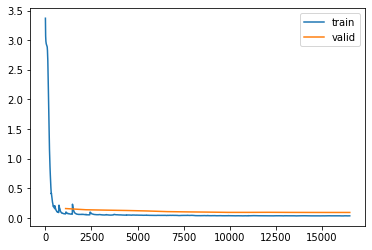

In [ ]:
learn.recorder.plot_loss()

In [ ]:
df_ha = pd.read_csv(path/'data/prot_sequences_influenza_ha_3_species.csv')
df_ha['sequences'] = df_ha['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x))
len(df_ha)

22845

In [ ]:
def extract_features(sequences, amino_acid_embeds, vocab):
  l=[]
  for i, sequence in enumerate(sequences):
    k=[]
    for aa in list(sequence):
      k.append(amino_acid_embeds[vocab.index(aa)].numpy())

    l.append(np.array(k).mean(0))
  return np.array(l)

  
prot_embeddings = extract_features(df_ha['sequences'], learn.model[0].encoder.weight.data.cpu()[3:25], dls_lm.vocab[3:25])
prot_embeddings.shape

(22845, 400)

In [ ]:
# embeds = learn.model[0].encoder.weight.data.cpu()[0:25]
# bos = embeds[0]
# embeds[0] = embeds[1]
# embeds[1] = bos

In [ ]:
# np.save(path/"embeddings/awdlstm_prot_embeds_32.npy", prot_embeddings)

# **Dimentionality Reduction**

We assessed the information captured by the embeddings extracted from the viral protein sequences using AWD-LSTM by projecting the high dimensional representations in two dimensional space (2D), using TSNE and UMAP. Toward this end, we choose to visualize the influenza A protein representations according to three major hosts (Human, Swine, Avian).

# 1- TSNE Projection

In [ ]:
embeds = TSNE(n_components=2, n_iter=3000).fit_transform(prot_embeddings)

In [ ]:
# np.save(path/"embeddings/tsne_awd_lstm_embeddings.npy", embeds)
embeds = np.load(path/"embeddings/tsne_awd_lstm_embeddings.npy")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


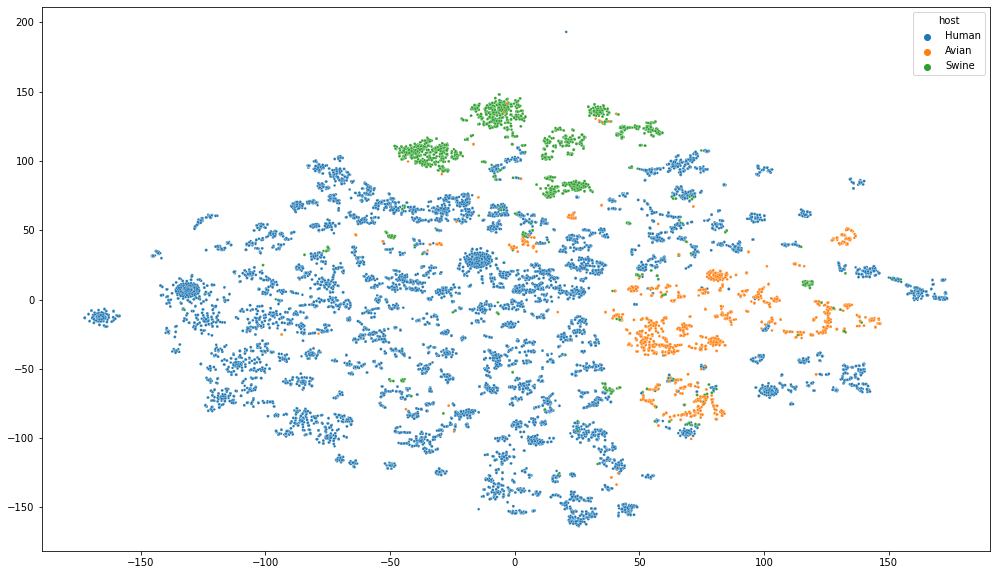

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
# ax.set_title('')
sns.scatterplot(embeds[:,0], embeds[:, 1], hue=df_ha['host'], s=7)
plt.savefig(path/'plots/results/awdlstm_tsne_ha')

In [ ]:
df_ha['date'] = df_ha['date'].fillna(1900)
df_ha['date'] = pd.to_datetime(df_ha['date'])

dat = (df_ha['date'].dt.year/10).apply(lambda x: int(x))
mon = (df_ha['date'].dt.month)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


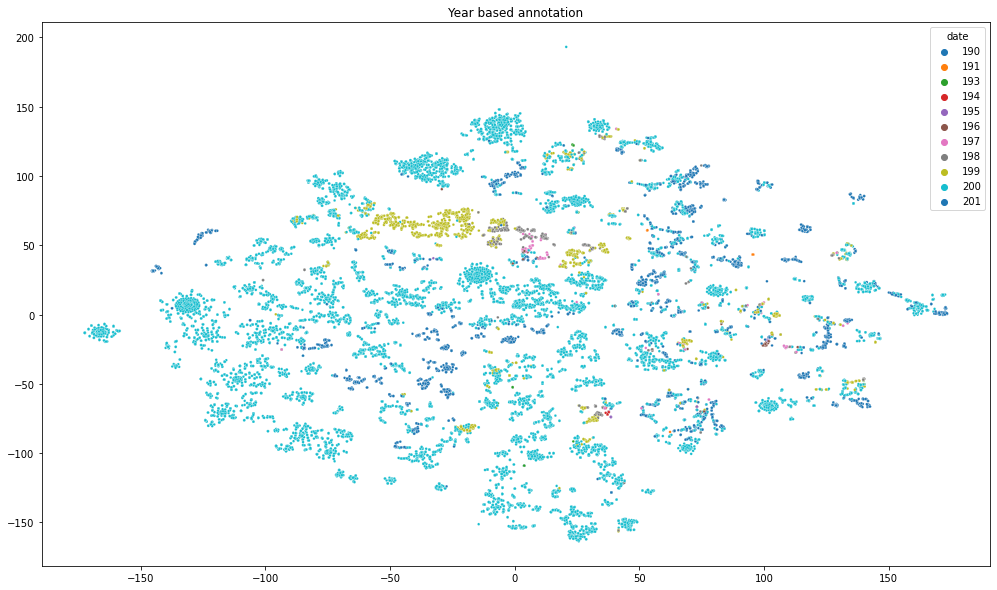

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Year based annotation')
sns.scatterplot(embeds[:, 0], embeds[:, 1], hue=dat, s=7, palette='tab10')

# 2- *UMAP* Projection

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=42)

In [ ]:
umap_embeds_2d = reducer.fit_transform(prot_embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


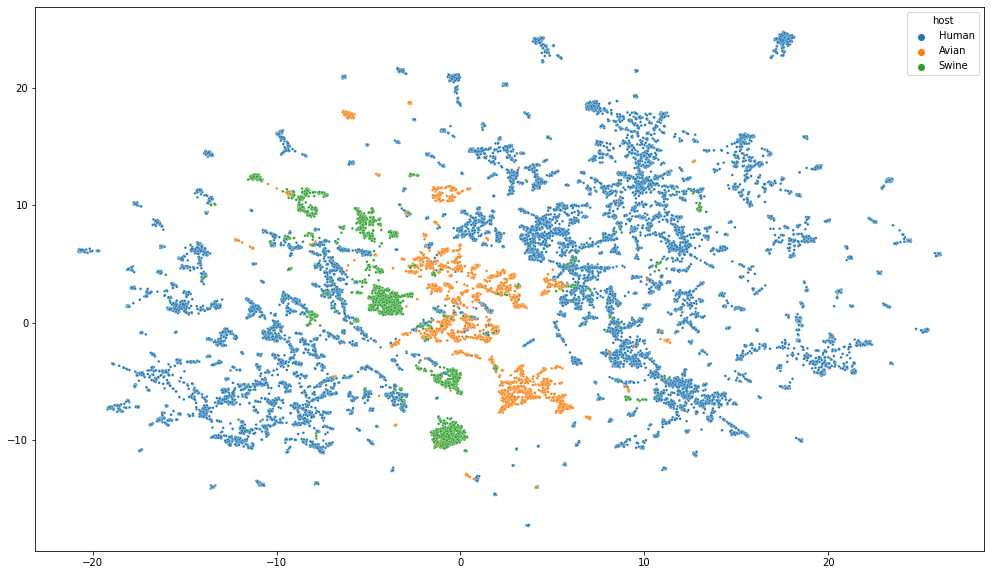

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df_ha['host'], s=7)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


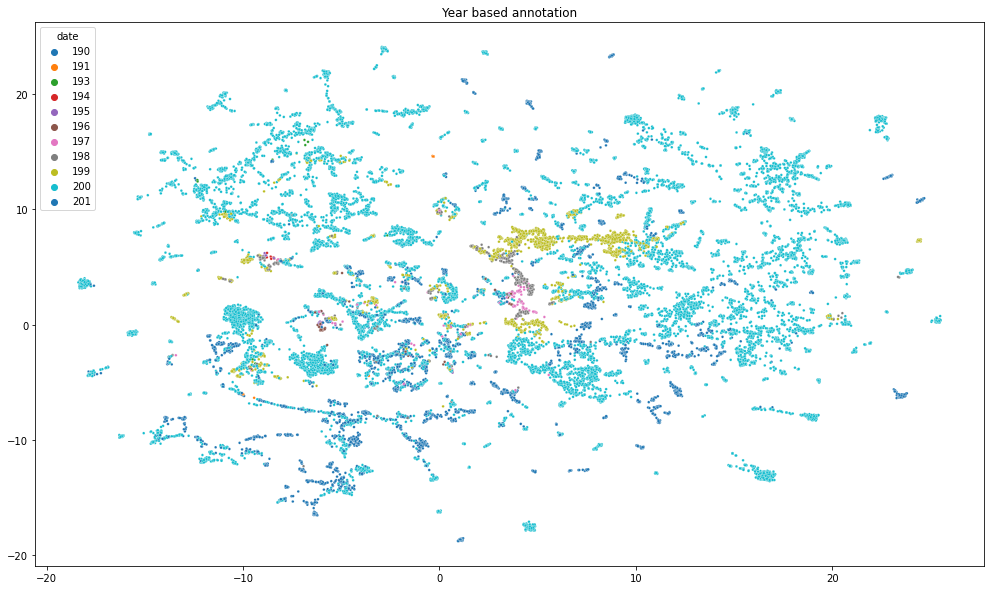

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Year based annotation')
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=dat, s=7, palette='tab10')

## **Using hidden states**

In [ ]:
df_ha = pd.read_csv(path/'data/prot_sequences_influenza_ha_3_species.csv')
df_ha['sequences'] = df_ha['sequences'].map(lambda x: re.sub(r"[UZOB]", "X", x))
len(df_ha)

22845

In [ ]:
tfms = [attrgetter("text"), Tokenizer.from_df(text_cols='sequences', tok=CharTokenizer(), rules=[]), Numericalize(special_toks=[BOS, PAD, EOS])]
dsets = Datasets(df_ha, [tfms], splits=None, dl_type=LMDataLoader)


dls_lm = dsets.dataloaders(bs=bs, seq_len=72)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
len(dsets[0][0])

347

In [ ]:
dls_lm.one_batch()[0].to(torch.device('cpu'))

LMTensorText([[ 4, 12, 14,  ..., 15,  3,  5],
        [15,  6, 13,  ..., 17,  4, 10],
        [ 4, 20, 14,  ...,  4, 12, 14],
        ...,
        [ 8, 18,  5,  ..., 13,  3,  6],
        [ 9, 15,  3,  ...,  3, 18, 16],
        [ 6, 15,  3,  ...,  9, 18,  7]])

In [ ]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(32, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(32, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=32, bias=True)
    (output_dp): RNNDropout()
  )
)

In [1]:
#out = learn.model(dsets[0][0])

In [ ]:
out[0].shape

torch.Size([128, 400, 32])

# **Protein Host Prediction**

To compare the representations produced by each model, we build different classifiers that use these representations as input to classify the sequences into three possible hosts that are Human, Swine or Avian.

# Classifiers

 Since the data is imbalanced with most sequences coming from human hosts, we balance our data using SMOTE (Synthetic Minority Oversampling Technique), where we do oversampling of the minority classes, SMOTE does this by synthesizing the samples along the class decision boundary. 

In [ ]:
# balance data with smote
from imblearn.over_sampling import SMOTE

X, y = prot_embeddings, df_ha['host']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X.shape, X_res.shape

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

((22845, 400), (52527, 400))

In [ ]:
y.value_counts()

Human    17509
Avian     2799
Swine     2537
Name: host, dtype: int64

In [ ]:
len(y_res[y_res=='Human']), len(y_res[y_res=='Avian']), len(y_res[y_res=='Swine'])

(17509, 17509, 17509)

After oversampling, we split the data randomly into train and test set, we used 30% of the data for testing the model, and the rest for training.

**Logistic Regression**

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

clf = LogisticRegression(random_state=42).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# accuracy
clf.score(X_test, y_test)

0.903483723586522

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.903472065200363

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.963036122387391

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification


clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
clf.score(X_test, y_test)

0.9161748841931595

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.9559101179270805

In [ ]:
# auc

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovo')

0.9652147363917495

**Support Vector Machine**


In [ ]:

from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [ ]:
clf.score(X_test, y_test)

0.8958690272225395

In [ ]:
# f1 score
from sklearn.metrics import f1_score

y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

0.8958003248869465

In [2]:
# auc

#from sklearn.metrics import roc_auc_score

#roc_auc_score(y_test, clf.decision_function(X_test), multi_class='ovo')

### Visualization with balancing

In [ ]:
embeds = TSNE(n_components=2, n_iter=3000).fit_transform(X_res)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


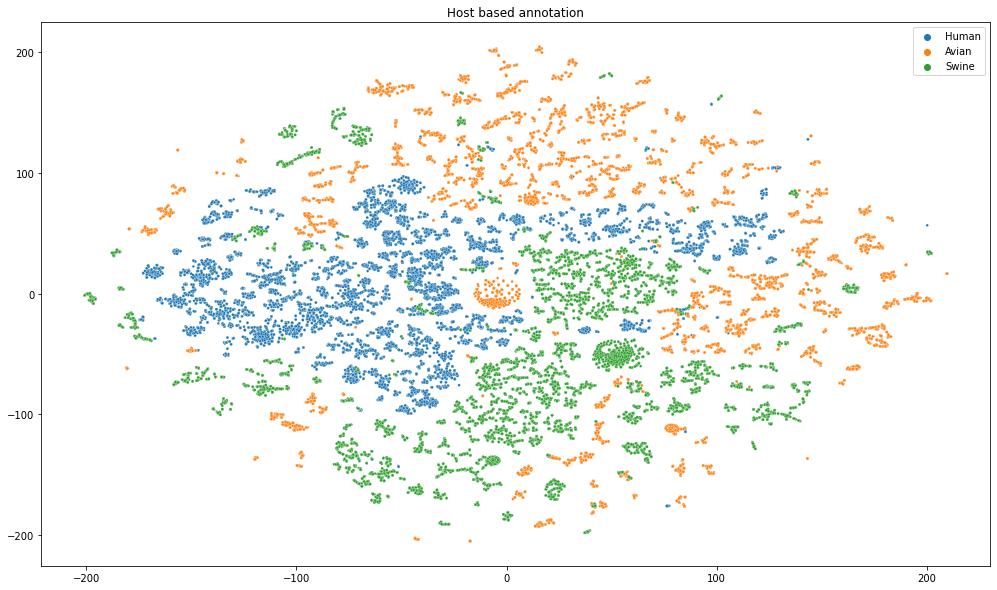

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
ax.set_title('Host based annotation')
sns.scatterplot(embeds[:,0], embeds[:, 1], hue=y_res, s=7)

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.5, random_state=42)


In [ ]:
umap_embeds_2d = reducer.fit_transform(prot_embeddings)


In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))
sns.scatterplot(umap_embeds_2d[:, 0], umap_embeds_2d[:, 1], hue=df_ha['host'], s=7)